# How does swell affect crevasses?

In [1]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams.update({'font.size': 16})

from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import multiprocessing
from functools import partial
from scipy.optimize import fminbound

import crevasse as c # main module for this project
from importlib import reload
reload(c)

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


<module 'crevasse' from '/home/bradlipovsky/notebooks/crevasserator/crevasse.py'>

### Define baseline parameters

In [2]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

Lcs = np.logspace(np.log10(5),np.log10(50e3),50)
r = mats['rho']/mats['rhow']

D, flexural_gravity_wavelength,lam = c.fgl(mats,geom)

KI_analytical, KI_analytical_bottom = c.analytical_KI(geom,mats)
KI_analytical_bending,KI_analytical_bending_bottom = c.analytical_KI_bending(geom,mats,Lcs)


In [53]:
def make_spatial_figure(surface_sifs,bottom_sifs,
                        Lcs_swell,output1,
                        Lcs_swell_2,output2,
                        save=False,
                        draw_analytical=True,
                        ylim=[-0.25,1.6],
                        prestress=[0,0]):
    
    labels=('Basal $K_I$','Surface $K_{I}$','Basal $K_{II}$','Surface $K_{II}$')
    letters=('A. ', 'B. ', 'C. ','D. ')
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))
    for i,this_ax in enumerate((ax1,ax2,ax3,ax4)):

        if i==0:
            sif_no_swell = bottom_sifs['KI']/1e6
        elif i ==1:
            sif_no_swell = surface_sifs['KI']/1e6
        if i==2:
            sif_no_swell = bottom_sifs['KII']/1e6
        elif i ==3:
            sif_no_swell = surface_sifs['KII']/1e6

        for j,output,lc in zip((0,1),(output2,output1),(Lcs_swell_2,Lcs_swell)):
        
            if i==0:
                swell_min = np.array(output['bottom KI min'])[:,1]/1e6
                swell_max = np.array(output['bottom KI max'])[:,1]/1e6
            elif i ==1:
                swell_min = np.array(output['surface KI min'])[:,1]/1e6
                swell_max = np.array(output['surface KI max'])[:,1]/1e6
            if i==2:
                swell_min = np.array(output['bottom KII min'])[:,1]/1e6
                swell_max = np.array(output['bottom KII max'])[:,1]/1e6
            elif i ==3:
                swell_min = np.array(output['surface KII min'])[:,1]/1e6
                swell_max = np.array(output['surface KII max'])[:,1]/1e6

            sif_no_swell_interp = np.interp(lc,Lcs,sif_no_swell)
            if j==0:
                col = 'lightgray'
            else:
                col = 'gray'
            this_ax.fill_between(lc/1e3, swell_max, swell_min, 
                             color=col, label='Swell Range')


        this_ax.plot(Lcs/1e3,sif_no_swell,label=labels[i],color='k',linewidth=2)
        this_ax.plot((0,20),(0.1,0.1),'--',label='Nominal Fracture Toughness of Ice',color='k')

        this_ax.set_xlim([0e3,flexural_gravity_wavelength*2/1e3])
        this_ax.set_ylim(ylim)
        
        this_ax.set_ylabel('Stress Intensity Factor, MPa $\sqrt{m}$', fontsize=16)
        this_ax.set_xlabel('Distance From Ice Front, km', fontsize=16)
        
        this_ax.set_title(letters[i]+labels[i]+' Stress Intensity Factors', fontsize=20)

        axes2 = this_ax.twiny()
        axes2.set_xticks([0,0.5,1,1.5,2])
        axes2.set_xlabel('Distance / Flexural Gravity Wavelength', fontsize=16)
        axes2.grid(False)

    fig.tight_layout()
    fig.legend(['SIF without Swell', 'Nominal Fracture Toughness', 
                'Swell range (30 s period)', 'Swell range (10 s period)'],
               loc='lower center',ncol=2)
    fig.subplots_adjust(bottom=0.15)   
    if save:
        plt.savefig('figures/sif-variation-with-swell.eps', format='eps')

#     return fig, ((ax1,ax2),(ax3,ax4))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


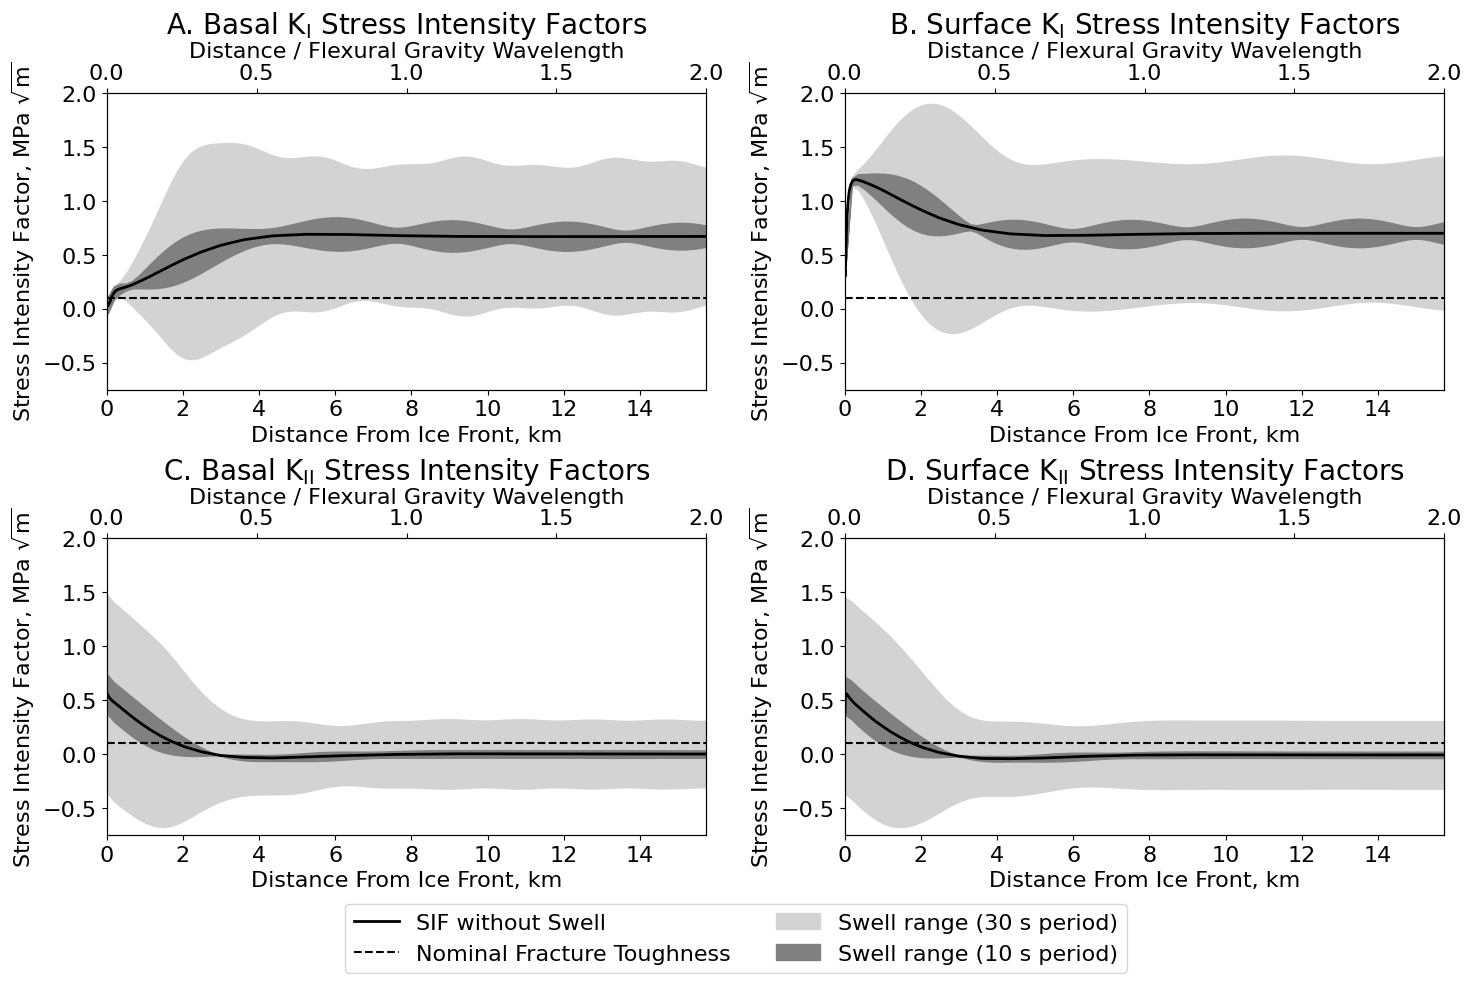

In [54]:
# The code to calculate swell sifs has been moved to run_crevasse_simulations.py
with open('output/sifs-surface-crevasses.pkl', 'rb') as f:
    surface_sifs = pickle.load(f)
    
with open('output/sifs-bottom-crevasses.pkl', 'rb') as f:
    bottom_sifs = pickle.load(f)
    
with open('output/sifs-10s-swell.pkl', 'rb') as f:
    output_10s = pickle.load(f)
    Lcs_10s = np.linspace(20,2*flexural_gravity_wavelength,len(output_10s['bottom KI min']))
    
with open('output/sifs-30s-swell.pkl', 'rb') as f:
    output_30s = pickle.load(f)
    Lcs_30s = np.linspace(20,2*flexural_gravity_wavelength,len(output_30s['bottom KI min']))
    
make_spatial_figure(surface_sifs,bottom_sifs,
                    Lcs_10s,output_10s,
                    Lcs_30s,output_30s,
                    save=True,
                    ylim=[-0.75,2])

In [43]:
with open('output/swell-sifs-one-Lc.pkl', 'rb') as f:
    output_one = pickle.load(f)
output_one

{'bottom KI max': (3.1174303053007, 764827.5445304491)}

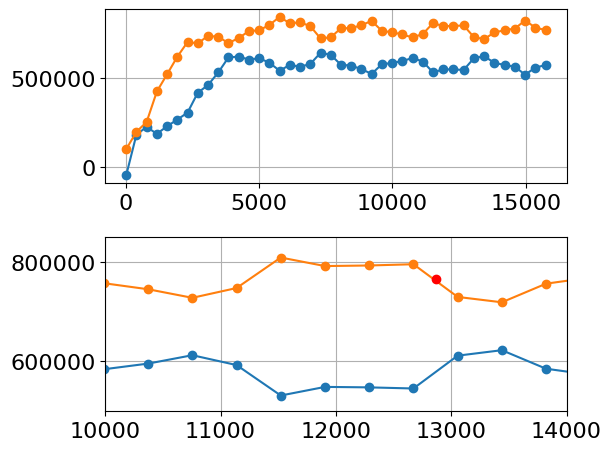

In [46]:
fig,ax=plt.subplots(2,1)
for x in ax:
    x.plot(Lcs_10s,np.array(output_10s['bottom KI min'])[:,1],'-o')
    x.plot(Lcs_10s,np.array(output_10s['bottom KI max'])[:,1],'-o')
    x.grid()
    
plt.plot((Lcs_10s[34] - Lcs_10s[33])/2 + Lcs_10s[33],output_one['bottom KI max'][1],'or')
plt.xlim([10e3,14e3])
plt.ylim([5e5,8.5e5])
plt.tight_layout()
plt.show()

12864.336243112473

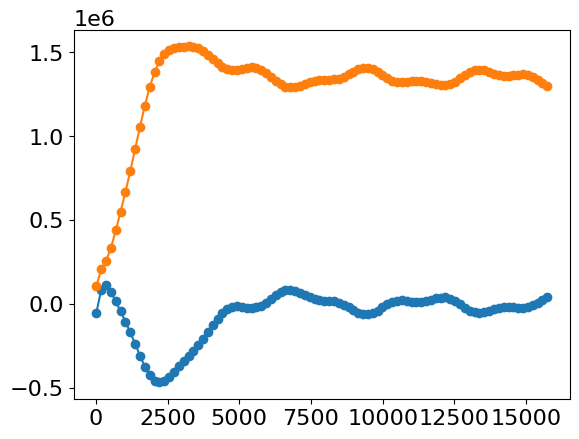

In [13]:
plt.plot(Lcs_30s,np.array(output_30s['bottom KI min'])[:,1],'-o')
plt.plot(Lcs_30s,np.array(output_30s['bottom KI max'])[:,1],'-o')